# Poissson Hidden Markov Models

In [69]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [70]:
from posteriors import gamma, dirichlet, simul_s, _poisson
from simulation import simul_poisson
from HMM import HMM

# We will fit a two component poisson HMM

A 2 components poisson HMM is made of :
* A posterior `gamma` distribution over $\theta = \lambda \in IR^2$
* A posterior distribution over $S \in IR^n$, the states vector; where $n = #obs$
* A posterior `dirichlet` distribution over the transition matrix $P \in IR^{2x2}$

We start by definig the posterior of $ \lambda$

In [71]:
tDictDist = {"_lambda": gamma()}

#Let set the default parameter
# tDictDist["_lambda"]._set(a = np.array([1, 1/2]))
# tDictDist["_lambda"]._set(scale = np.array([1/2, 1]))
tDictDist["_lambda"]._set_default(a = np.array([1, 1/2]))
tDictDist["_lambda"]._set_default(scale = np.array([1/2, 1]))

Now, the **S** distribtuion ...

In [72]:
sDist = simul_s(func = _poisson) # S distribution

Now the $P$ distribution

In [73]:
pDist = dirichlet() # A dirichlet distribution is common for probability vectors
pDist._set(a = np.array([[0.5, 0.5], [0.5,0.5]]))

In [74]:
pDist.default

{'a': 1}

# The poisson mixture on an artificial data

Let's simulate an artificial poisson mixture

In [93]:
P0 = np.array([[0.2, 0.8], [0.6, 0.4]]) # the 'true' transition matrix
theta0 = np.array([1., 10.]) # The true lambdas

(array([491.,  55.,  46.,  92., 103., 143.,  41.,  19.,   8.,   2.]),
 array([ 0. ,  2.2,  4.4,  6.6,  8.8, 11. , 13.2, 15.4, 17.6, 19.8, 22. ]),
 <a list of 10 Patch objects>)

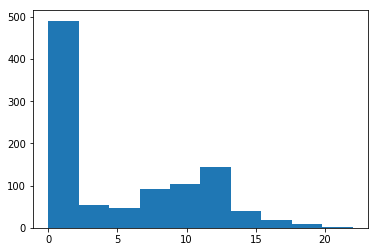

In [104]:
y, SS0 = simul_poisson(P0, theta0, size = 1000) # Simulate 300 sample of poisson mixtures
plt.hist(y)

In [105]:
Y = y
Theta = {"_lambda" : np.array([5,5])} # Initial lambdas, any !
S = np.random.choice(2, len(Y)) # Initial S, random !
P = np.array([[0.5,0.5],[0.5,0.5]]) # Initial P, any !

In [106]:
phmm = HMM(tDictDist, sDist, pDist, Y=Y, S = S, Theta = Theta, P = P )

In [107]:
phmm.run(150) # Start the gibbs sampler n-times

# Can we recover the true clusters ? Let's see !

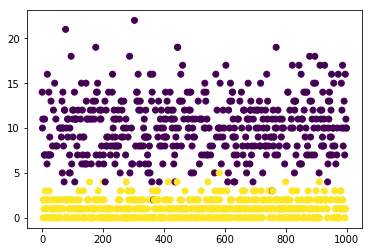

In [108]:
plt.scatter(np.arange(len(Y)), Y, c= phmm.S)

In [120]:
(phmm.S == SS0).mean() # Precision or Error rate

0.024

In [121]:
phmm.Theta

{'_lambda': array([10.25673551,  1.06314112])}

In [122]:
_lambda = phmm.tListDictDist["_lambda"]
_lambda.params, _lambda.default

({'a': array([4734. ,  593.5]), 'scale': array([0.0021645 , 0.00184843])},
 {'a0': 1, 'scale0': 1, 'a': array([1. , 0.5]), 'scale': array([0.5, 1. ])})

In [123]:
_lambda.rvs().round(2) # Our estimates are quite good !!!

array([9.99, 1.07])

In [124]:
phmm.H["Theta"][-10::] # Last 10 lambda samples

[{'_lambda': array([9.99852717, 1.05028364])},
 {'_lambda': array([10.353712  ,  1.09623347])},
 {'_lambda': array([10.07581817,  1.09715508])},
 {'_lambda': array([10.27867311,  1.09611885])},
 {'_lambda': array([9.91712768, 1.02138667])},
 {'_lambda': array([10.44697069,  1.1664171 ])},
 {'_lambda': array([10.08380911,  1.04498704])},
 {'_lambda': array([10.30542974,  1.12960139])},
 {'_lambda': array([10.19368078,  1.11851472])},
 {'_lambda': array([10.43107281,  1.09475228])}]

In [125]:
phmm.H["P"][-10::] # Last ten sample of P

[array([[0.44120237, 0.55879763],
        [0.46871975, 0.53128025]]), array([[0.45058218, 0.54941782],
        [0.47718298, 0.52281702]]), array([[0.45096255, 0.54903745],
        [0.48718689, 0.51281311]]), array([[0.44898388, 0.55101612],
        [0.50275785, 0.49724215]]), array([[0.48402959, 0.51597041],
        [0.48028044, 0.51971956]]), array([[0.48892365, 0.51107635],
        [0.46679808, 0.53320192]]), array([[0.45069326, 0.54930674],
        [0.48039812, 0.51960188]]), array([[0.45666376, 0.54333624],
        [0.44540664, 0.55459336]]), array([[0.4484794 , 0.5515206 ],
        [0.47168815, 0.52831185]]), array([[0.45637465, 0.54362535],
        [0.4625088 , 0.5374912 ]])]